# MNIST practice

In [3]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

cuda = torch.cuda.is_available()
cuda

False

In [9]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
trainData = train.train_data
trainData = train.transform(trainData.numpy())

print('[Train Data]')
print('- Numpy Shape : ', trainData.cpu().numpy().shape)
print('- Tensor Shape : ', trainData.size())
print('- Min : ', torch.min(trainData))
print('- Max : ', torch.max(trainData))
print('- Mean : ', torch.mean(trainData))
print('- Std : ', torch.std(trainData))
print('- Var : ', torch.var(trainData))

print('\n[Train Lables]')
print('- Numpy Shape : ', train.train_labels.cpu().numpy().shape)
print('- Tensor Shape : ', train.train_labels.size())

[Train Data]
- Numpy Shape :  (28, 60000, 28)
- Tensor Shape :  torch.Size([28, 60000, 28])
- Min :  tensor(0.)
- Max :  tensor(1.)
- Mean :  tensor(0.1305)
- Std :  tensor(0.3081)
- Var :  tensor(0.0949)

[Train Lables]
- Numpy Shape :  (60000,)
- Tensor Shape :  torch.Size([60000])


/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


5


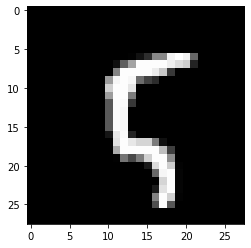

In [13]:
# Visuablize a training instance with matplotlib 
plt.imshow(train.train_data.cpu().numpy()[0], cmap='gray')
print(train.train_labels.cpu().numpy()[0])

0


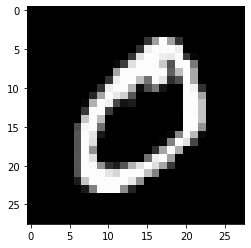

In [14]:
plt.imshow(train.train_data.cpu().numpy()[1], cmap='gray')
print(train.train_labels.cpu().numpy()[1])

In [15]:
# Dataloader

class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, index):
        X = self.X[index].float().reshape(-1) #flatten the input
        Y = self.Y[index].long()
        return X,Y

In [46]:
numWorkers = 8 if cuda else 0

# Training
trainDataset = MyDataset(train.train_data, train.train_labels)
trainLoaderArgs = dict(shuffle=True, batch_size=256, num_workers=numWorkers, pin_memory=True) if cuda\
                  else dict(shuffle=True, batch_size=64)
trainLoader = data.DataLoader(trainDataset, **trainLoaderArgs)

# Testing
testDataset = MyDataset(test.test_data, test.test_labels)
testLoaderArgs = dict(shuffle=False, batch_size=256, num_workers=numWorkers, pin_memory=True) if cuda\
                  else dict(shuffle=False, batch_size=1)
# When set test, shuffle is False
testLoader = data.DataLoader(testDataset, **testLoaderArgs)

/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#trainLoader = data.DataLoader(trainDateset, **trainLoaderArgs)
#testLoader = data.DataLoader(testDataset, **testLoaderArgs)

In [47]:
# Define Neural Network Model
# Simple Model Definition
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i], size_list[i+1]))
            layers.append(nn.ReLU())
        # what is below code?
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [48]:
# Create the model and define the Loss and Optimizer
model = Simple_MLP([784, 256, 10])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [49]:
# Create a function that will train the network for one epoch
def train_epoch(model, trainLoader, criterion, optimzer):
    model.train()
    
    runningLoss = 0.0
    
    startTime = time.time()
    for batchIdx, (data, target) in enumerate(trainLoader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        outputs = model(data)
        loss = criterion(outputs, target)
        runningLoss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    runningLoss /= len(trainLoader)
    print('Training Loss : ', runningLoss, 'Time : ', end_time - startTime, 's')
    return runningLoss

In [50]:
# Create a function that will evaluate our network's performance on the test set
def test_model(model, testLoader, criterion):
    with torch.no_grad():
        model.eval()
        
        runningLoss = 0.0
        totalPredictions = 0.0
        correctPredictions = 0.0
        
        for batchIdx, (data, target) in enumerate(testLoader):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            _, predicted = torch.max(outputs.data, 1)
            totalPredictions += target.size(0)
            correctPredictions += (predicted == target).sum().item()
            
            loss = criterion(outputs, target).detach()
            runningLoss += loss.item()
            
        runningLoss /= len(testLoader)
        acc = (correctPredictions/totalPredictions)*100.0
        print('Testing Loss : ', runningLoss)
        print('Testing Accuracy : ', acc, '%')
        return runningLoss, acc

In [51]:
# Train the model for N epochs
nEpoch = 10
TrainLoss = []
TestLoss = []
TestAcc = []

for i in range(nEpoch):
    trainLoss = train_epoch(model, trainLoader, criterion, optimizer)
    testLoss, testAcc = test_model(model, testLoader, criterion)
    TrainLoss.append(trainLoss)
    TestLoss.append(testLoss)
    TestAcc.append(testAcc)
    print('='*20)
print('==finish==')

Training Loss :  0.559401784225234 Time :  2.8858988285064697 s
Testing Loss :  0.18683291727788456
Testing Accuracy :  95.21 %
Training Loss :  0.17195734833585602 Time :  3.1850528717041016 s
Testing Loss :  0.2186228641929451
Testing Accuracy :  94.62 %
Training Loss :  0.1536391290796569 Time :  3.3439269065856934 s
Testing Loss :  0.23225710690086038
Testing Accuracy :  94.99 %
Training Loss :  0.15147535404391976 Time :  3.4497177600860596 s
Testing Loss :  0.20835079471619283
Testing Accuracy :  95.34 %
Training Loss :  0.15354415211394162 Time :  3.6370749473571777 s
Testing Loss :  0.236838713865547
Testing Accuracy :  95.08 %
Training Loss :  0.14825220400299843 Time :  4.0430920124053955 s
Testing Loss :  0.2280929595175512
Testing Accuracy :  95.54 %
Training Loss :  0.1432642964281957 Time :  4.2051520347595215 s
Testing Loss :  0.21803487873612776
Testing Accuracy :  95.87 %
Training Loss :  0.13676294223067842 Time :  4.372352123260498 s
Testing Loss :  0.236306021623984

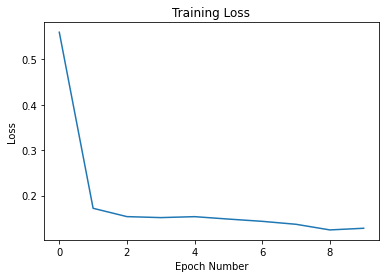

In [52]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(TrainLoss)

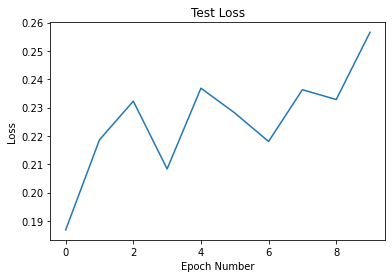

In [53]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(TestLoss)

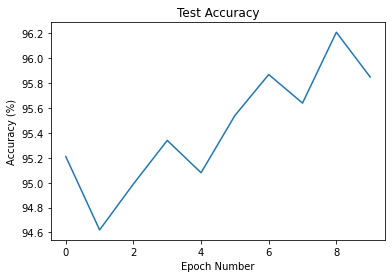

In [54]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(TestAcc)